# Hotel Bookings, Cancelled or not?

# Table of Contents:
* [Abstract](#1)
* [Libraries used](#2)
* [Data](#3)
* [EDA](#4)
* [Data Preprocessing](#5)
* [Model training](#6)
* [Results](#7)

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score

<a id='3'></a>

In [2]:
#loading data
pd.set_option('display.max_columns',None)
df=pd.read_csv('/kaggle/input/hotel-booking-demand/hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
#checking for null values
dict_={}
for feature in df.columns:
    dict_[feature]=df[feature].isnull().sum()
pd.DataFrame(dict_,index=['null_values']).transpose()

,null_values
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [5]:
#since company has approximately 95% null values it's better to drop it
df.drop('company',axis=1,inplace=True)

In [6]:
#for total number of guests
df['Total_guests']=df['adults']+df['children']+df['babies']

In [7]:
df[df['Total_guests']==0].value_counts().sum()

120

In [8]:
#since it's not possible that someone will make bookings and the number of guests be zero
no_guests=df['Total_guests']==0
df=df[~no_guests]

In [9]:
#dropping total guests
df.drop('Total_guests',axis=1,inplace=True)

<a id='4'></a>
# Exploratory Data Analysis

In [10]:
#No of unique variables for each columns
dict_={}
for feature in df.columns:
    dict_[feature]=df[feature].value_counts().shape[0]
pd.DataFrame(dict_,index=['unique_counts']).transpose()

,unique_counts
hotel,2
is_canceled,2
lead_time,479
arrival_date_year,3
arrival_date_month,12
arrival_date_week_number,53
arrival_date_day_of_month,31
stays_in_weekend_nights,17
stays_in_week_nights,33
adults,14


<AxesSubplot:xlabel='market_segment', ylabel='count'>

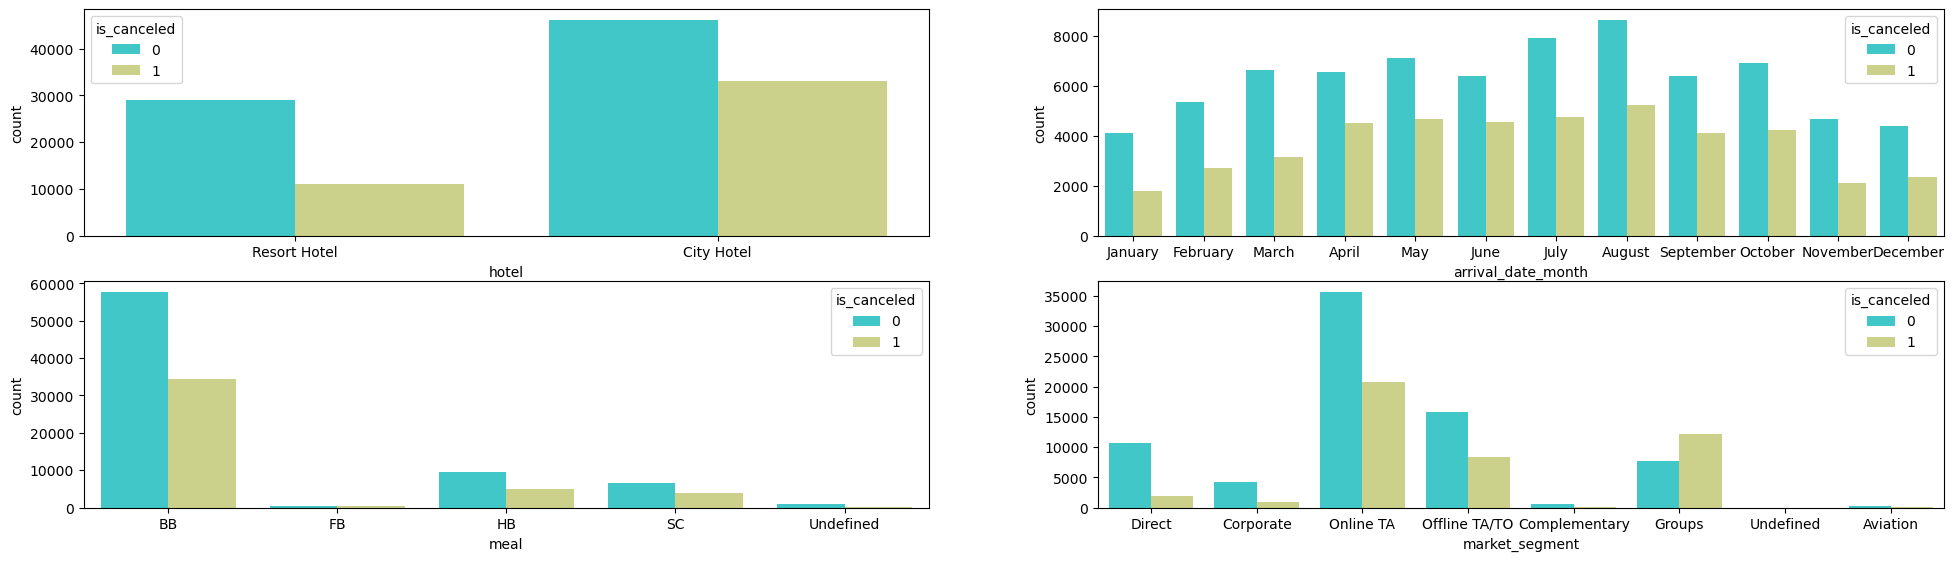

In [11]:
fig=plt.figure(figsize=(24,10))
ax=[None for _ in range(4)]
ax[0]=plt.subplot2grid((3,2),(0,0))
ax[1]=plt.subplot2grid((3,2),(0,1))
ax[2]=plt.subplot2grid((3,2),(1,0))
ax[3]=plt.subplot2grid((3,2),(1,1))
sns.countplot(x='hotel',data=df,ax=ax[0],hue='is_canceled',palette='rainbow')
sns.countplot(x='arrival_date_month',data=df,ax=ax[1],hue='is_canceled',palette='rainbow',order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
sns.countplot(x='meal',data=df,ax=ax[2],hue='is_canceled',palette='rainbow')
sns.countplot(x='market_segment',data=df,ax=ax[3],hue='is_canceled',palette='rainbow')

* **The proportion of bookings getting cancelled in city hotel in more than in resorts**
* **The proportion of ratained cancelled bookings seems to be relatively stable throughout the month**
* **The bookings with selected meal type 'FB' i.e., Full Board are most likely to get canceled**

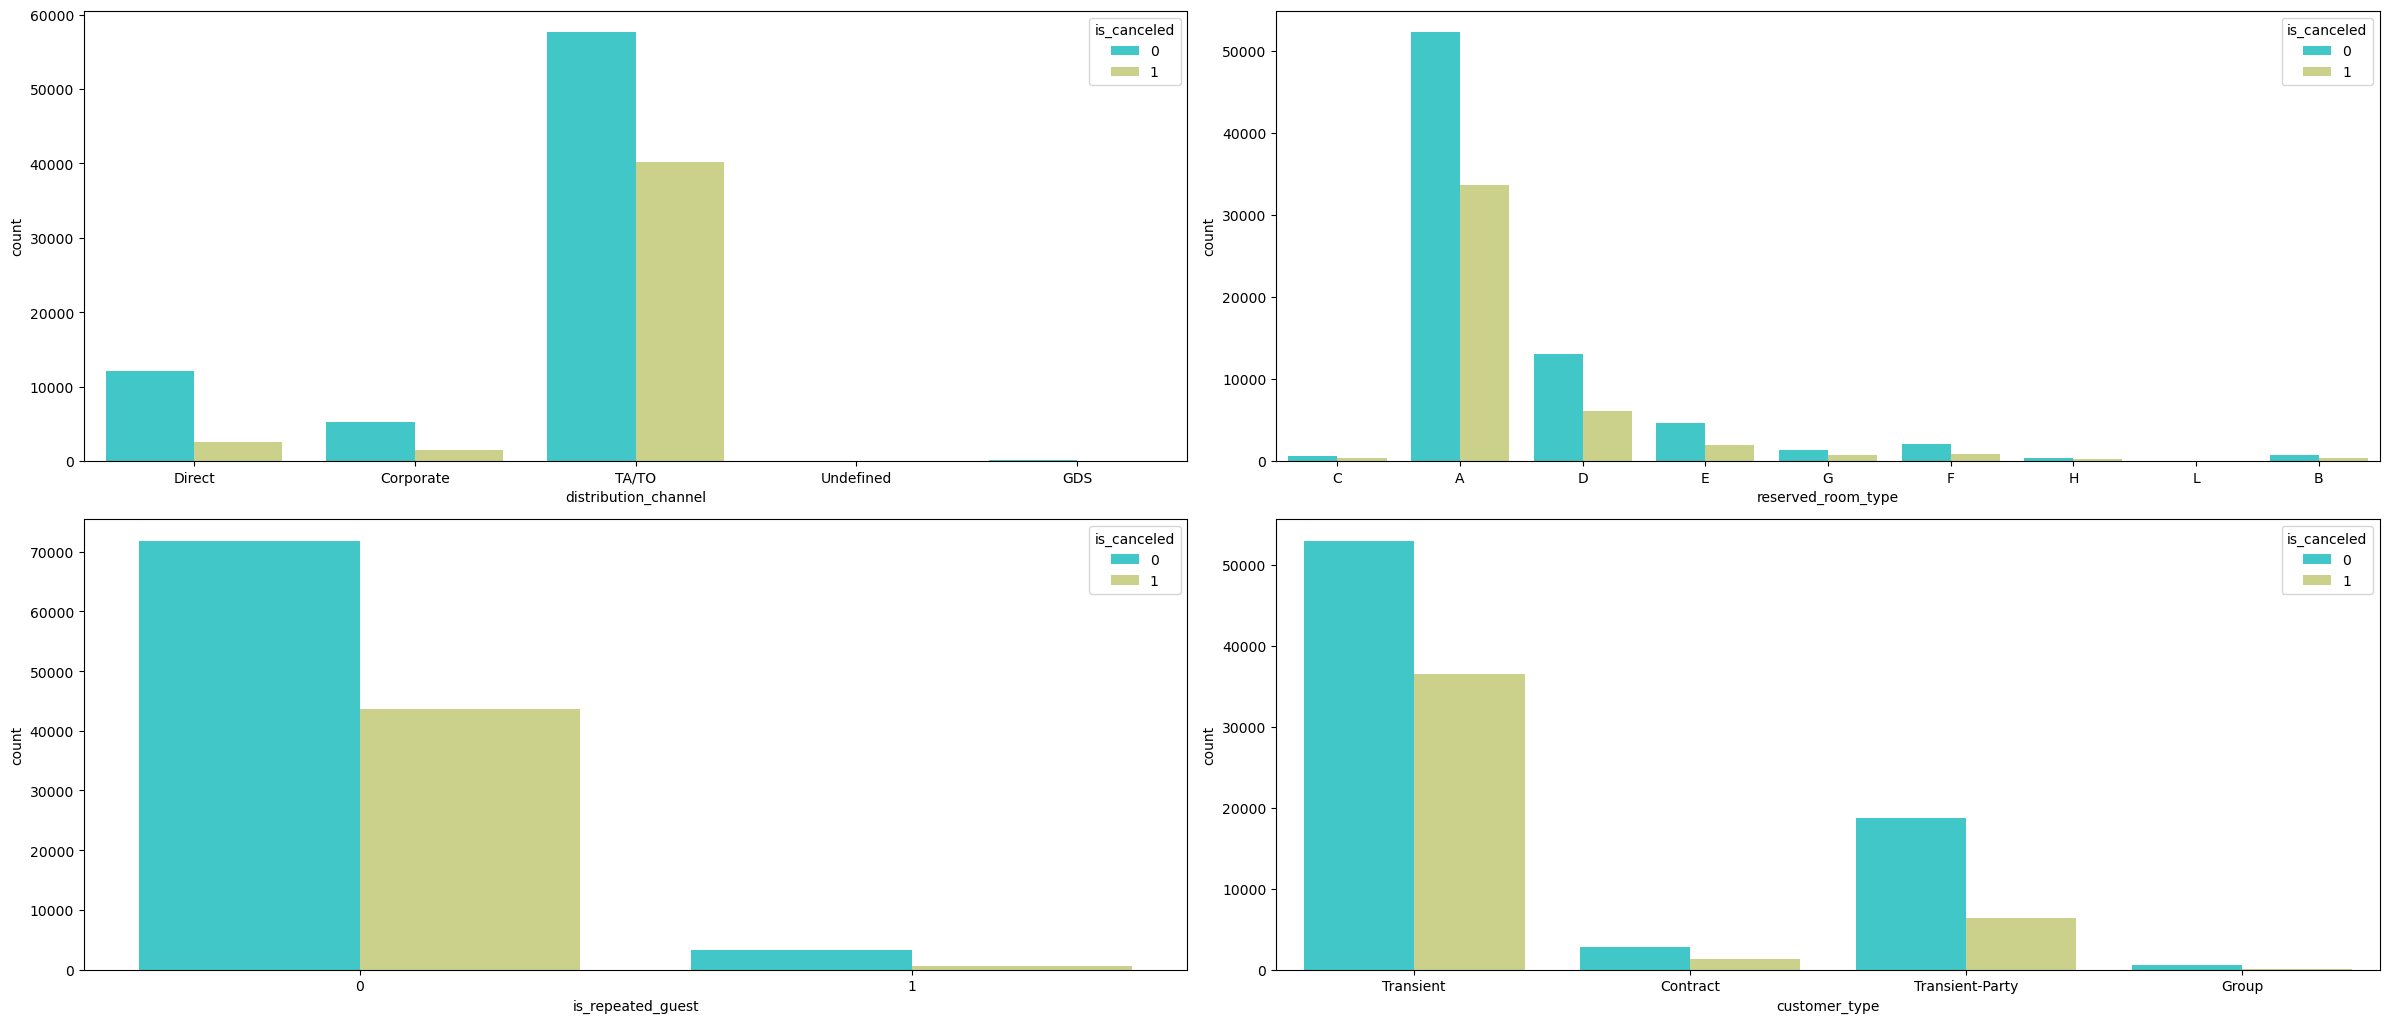

In [12]:
fig=plt.figure(figsize=(24,15))
ax=[None for _ in range(4)]
ax[0]=plt.subplot2grid((3,2),(0,0))
ax[1]=plt.subplot2grid((3,2),(0,1))
ax[2]=plt.subplot2grid((3,2),(1,0))
ax[3]=plt.subplot2grid((3,2),(1,1))
sns.countplot(x='distribution_channel',data=df,ax=ax[0],hue='is_canceled',palette='rainbow')
sns.countplot(x='reserved_room_type',data=df,ax=ax[1],hue='is_canceled',palette='rainbow')
sns.countplot(x='is_repeated_guest',data=df,ax=ax[2],hue='is_canceled',palette='rainbow')
sns.countplot(x='customer_type',data=df,ax=ax[3],hue='is_canceled',palette='rainbow')
plt.tight_layout()

* **Bookings made through Direct, corporate and GDS channel are typically kept however bookings through TA/TO, retained bookings and cancelled bookings are almost proportional.**
* **Retained and cancelled bookings for different room types are typically proportional.**
* **Repeated guests are much more likely to retain the bookings.**

<AxesSubplot:xlabel='days_in_waiting_list', ylabel='Density'>

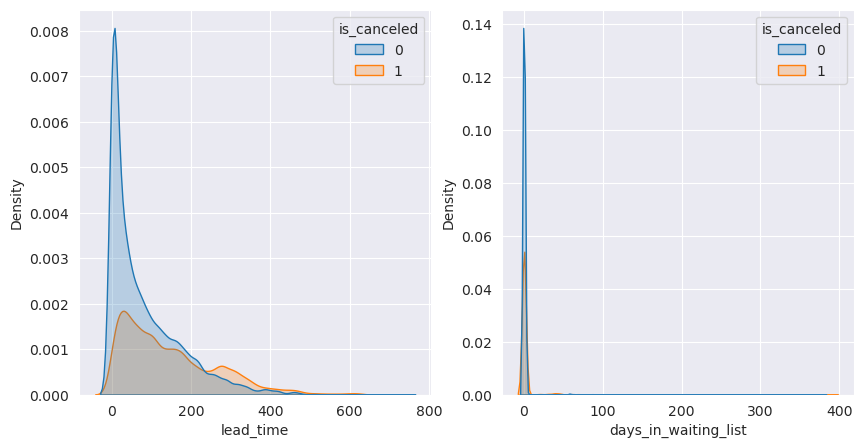

In [13]:
sns.set_style('darkgrid')
fig=plt.figure(figsize=(10,5))
ax[0]=plt.subplot2grid((1,2),(0,0))
ax[1]=plt.subplot2grid((1,2),(0,1))
sns.kdeplot(x='lead_time',data=df,hue='is_canceled',fill=True,ax=ax[0])
sns.kdeplot(x='days_in_waiting_list',data=df,hue='is_canceled',fill=True,ax=ax[1])

**'lead_time' is typically lower for bookings that are retained, this suggests that the sooner the bookings are made customers are less likely to cancel it and lower the days in the 'days_in_waiting_list' less likely the bookings will get canceled**

**Price corresponding to different room types**

<AxesSubplot:xlabel='reserved_room_type', ylabel='adr'>

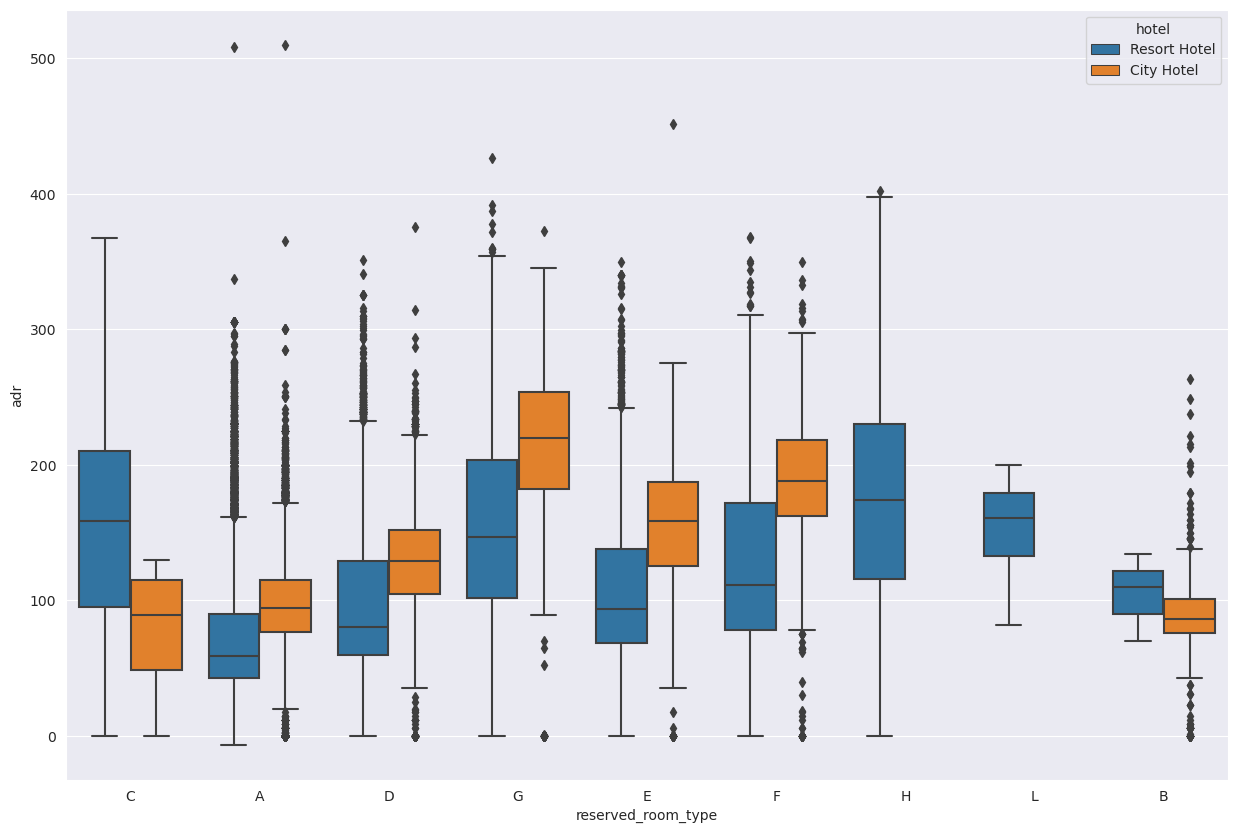

In [14]:
fig=plt.figure(figsize=(15,10))
sns.boxplot(x='reserved_room_type',y='adr',data=df[df['is_canceled']==0],hue='hotel')

* **Price depends on the room type one selects and also varies with the hotel**

* **To observe number of bookings over the year**

Text(0, 0.5, 'No. of Guests')

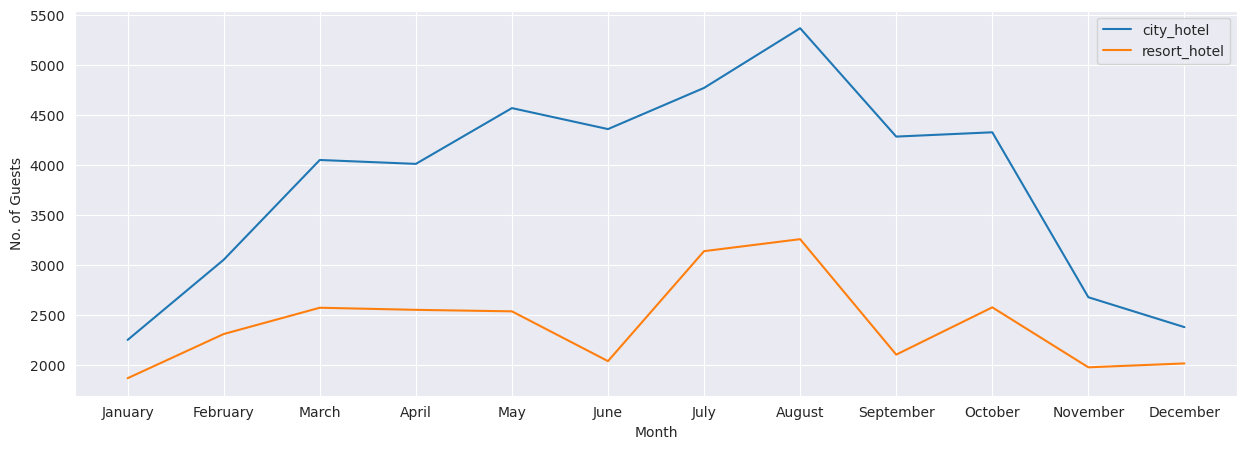

In [15]:
#bookings in city_hotel each month
city_hotel=df[df['hotel']=='City Hotel']
city_hotel=city_hotel[city_hotel['is_canceled']==0]
bookings_city_hotel_month=city_hotel.groupby('arrival_date_month',as_index=False)['hotel'].count()
bookings_city_hotel_month.rename(columns={'hotel':'city_hotel'},inplace=True)
#bookings in resort_hotel each month
resort_hotel=df[df['hotel']=='Resort Hotel']
resort_hotel=resort_hotel[resort_hotel['is_canceled']==0]
bookings_resort_hotel_month=resort_hotel.groupby('arrival_date_month',as_index=False)['hotel'].count()
bookings_resort_hotel_month.rename(columns={'hotel':'resort_hotel'},inplace=True)

#combined bookings
total_bookings=bookings_city_hotel_month.merge(bookings_resort_hotel_month,on='arrival_date_month')
total_bookings.rename(columns={'arrival_date_month':'month'},inplace=True)

#since month data is not in sorted order we need to sort it in the order jan,feb,march....
month_dict = {'January':1,'February':2,'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
total_bookings=total_bookings.sort_values('month', key = lambda x : x.apply (lambda x : month_dict[x]))

#plotting
fig,axes=plt.subplots(figsize=(15,5))
plt.plot('month','city_hotel',data=total_bookings,label='city_hotel')
plt.plot('month','resort_hotel',data=total_bookings,label='resort_hotel')
plt.legend()
plt.xlabel('Month')
plt.ylabel('No. of Guests')

* **City hotel has more guests than resort hotel during any time of the year.**
* **No. of guests are highest during the months of July and August in both the hotels and are lowest during the January and December.**

<a id='5'></a>
# Data Preprocessing

**correlation**

<AxesSubplot:>

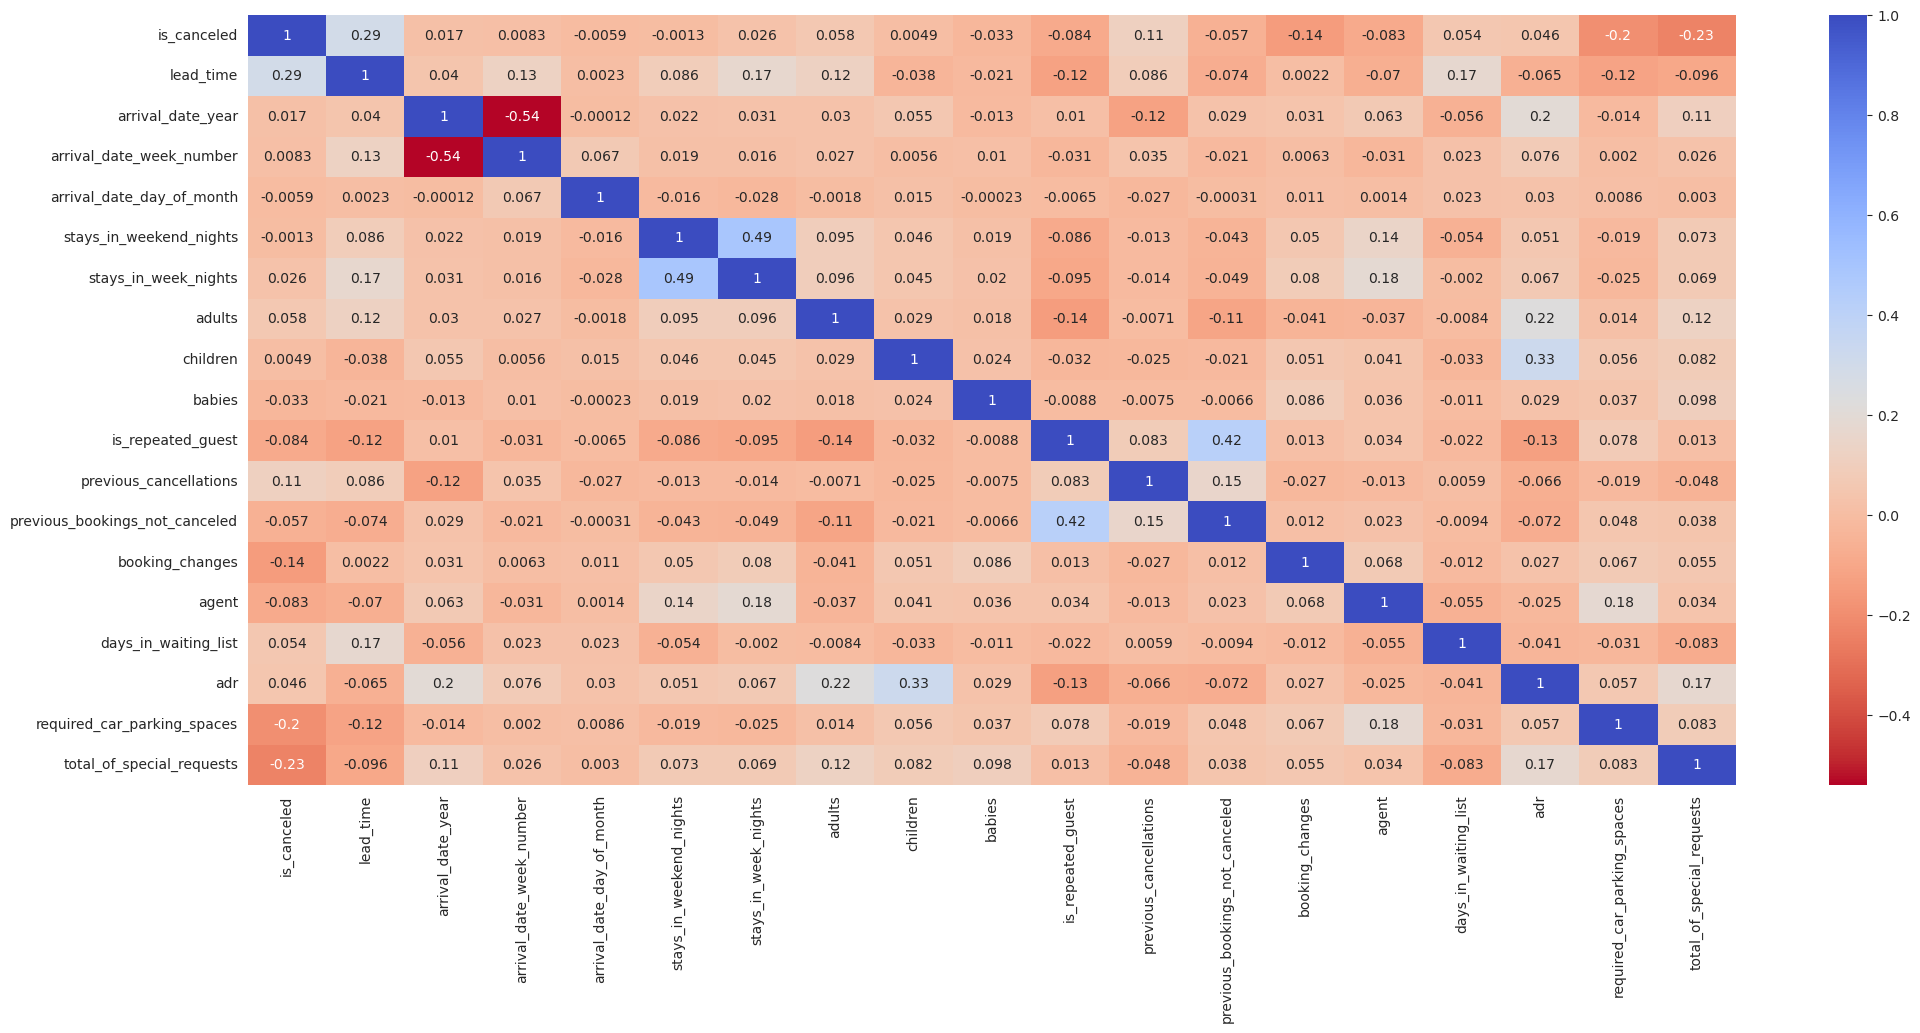

In [16]:
plt.figure(figsize=(24,10))
corr=df.corr()
sns.heatmap(corr,cmap='coolwarm_r',annot=True,annot_kws={'size':10})

In [17]:
df.corr()['is_canceled'].abs().sort_values()

stays_in_weekend_nights           0.001323
children                          0.004862
arrival_date_day_of_month         0.005948
arrival_date_week_number          0.008315
arrival_date_year                 0.016622
stays_in_week_nights              0.025542
babies                            0.032569
adr                               0.046492
days_in_waiting_list              0.054301
previous_bookings_not_canceled    0.057365
adults                            0.058182
agent                             0.083389
is_repeated_guest                 0.083745
previous_cancellations            0.110139
booking_changes                   0.144832
required_car_parking_spaces       0.195701
total_of_special_requests         0.234877
lead_time                         0.292876
is_canceled                       1.000000
Name: is_canceled, dtype: float64

In [18]:
df.drop(['arrival_date_week_number','arrival_date_day_of_month','reservation_status','arrival_date_year','assigned_room_type','booking_changes'],axis=1,inplace=True)

**Features Dropped:**
* arrival_date_week_number
* arrival_date_day_of_month
* reservation_status
* arrival_date_year
* assigned_room_type
* booking_changes

In [19]:
#imputing null values
df['children']=np.where(df['children'].isnull(),0,df['children'])
df['country']=np.where(df['country'].isnull(),df['country'].mode()[0],df['country'])
df['agent']=np.where(df['agent'].isnull(),0,df['agent'])

In [20]:
#dividing the features into categorical and continuous variables
categorical_feature=[feature for feature in df.columns if df[feature].dtype=='object']
continuous_feature=[feature for feature in df.columns if df[feature].dtype!='object']

**Ideally Some features needs to be removed from the list continuous feature and should be added to categorical_feature. 'is_canceled' is obviously one of them. From the unique value count table we can see that 'is_repeated_guest' is categorical i.e., its value is either 0 or 1. and agent feature it's like id of tracel agency thorough which bookings are made.But since i'm going to use label encoding for the categorical features either way it's gonna work**

In [21]:
#separating the categorical and continuos features 
df_cat=df[categorical_feature]
df_num=df[continuous_feature]

In [22]:
#extracting the date and month from reservation_status_date
df_cat['year']=df_cat['reservation_status_date'].str.split('-',expand=True)[0].astype(str).astype(int)
df_cat['month']=df_cat['reservation_status_date'].str.split('-',expand=True)[1].astype(str).astype(int)

In [23]:
df_cat.drop('reservation_status_date',axis=1,inplace=True)

In [24]:
df_cat.head(3)

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month
0,Resort Hotel,July,BB,PRT,Direct,Direct,C,No Deposit,Transient,2015,7
1,Resort Hotel,July,BB,PRT,Direct,Direct,C,No Deposit,Transient,2015,7
2,Resort Hotel,July,BB,GBR,Direct,Direct,A,No Deposit,Transient,2015,7


*Encoding the categorical feature*

In [25]:
encoder=LabelEncoder()
dict_cat={}
for feature in df_cat.columns:
    dict_cat[feature]=encoder.fit_transform(df_cat[feature])
#converting back the encoded feature into dataframe
df_cat=pd.DataFrame(dict_cat)

In [26]:
df_num.head(3)

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,0,0,2,0.0,0,0,0,0,0.0,0,0.0,0,0
1,0,737,0,0,2,0.0,0,0,0,0,0.0,0,0.0,0,0
2,0,7,0,1,1,0.0,0,0,0,0,0.0,0,75.0,0,0


In [27]:
df_num.drop('is_canceled',axis=1,inplace=True)

In [28]:
#Scaling of the numerical
scaler=MinMaxScaler()
df_num=pd.DataFrame(scaler.fit_transform(df_num),columns=df_num.columns)

*Combining both categorical and numerical dataframes*

In [29]:
df_new=pd.concat([df_num,df_cat],axis=1)
df_new.head(3)

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month
0,0.464043,0.0,0.00,0.036364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001180,0.0,0.0,1,5,0,135,3,1,2,0,2,1,6
1,1.000000,0.0,0.00,0.036364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001180,0.0,0.0,1,5,0,135,3,1,2,0,2,1,6
2,0.009498,0.0,0.02,0.018182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015053,0.0,0.0,1,5,0,59,3,1,0,0,2,1,6


<a id='6'></a>
# Model Training

In [30]:
#splitting the data in training and test set
y=df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size = 0.30)

# Logistic Regression Classifier

In [31]:
log_reg=LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred=log_reg.predict(X_test)
print('accuracy_score:{}'.format(accuracy_score(y_test,y_pred)))
print('f1_score:{}'.format(f1_score(y_test,y_pred)))
print('precision:{}'.format(precision_score(y_test,y_pred)))
print('recall:{}'.format(recall_score(y_test,y_pred)))

accuracy_score:0.7758018063361575
f1_score:0.6168769113149848
precision:0.8350582147477361
recall:0.4890892559478709


# SGD Classifier

In [32]:
sgd=SGDClassifier()
sgd.fit(X_train,y_train)
y_pred=sgd.predict(X_test)
print('accuracy_score:{}'.format(accuracy_score(y_test,y_pred)))
print('f1_score:{}'.format(f1_score(y_test,y_pred)))
print('precision:{}'.format(precision_score(y_test,y_pred)))
print('recall:{}'.format(recall_score(y_test,y_pred)))

accuracy_score:0.7582976819618041
f1_score:0.6881898852896616
precision:0.6567749931148444
recall:0.722761024397636


# KNN

In [33]:
KNN=KNeighborsClassifier()
KNN.fit(X_train,y_train)
y_pred=KNN.predict(X_test)
print('accuracy_score:{}'.format(accuracy_score(y_test,y_pred)))
print('f1_score:{}'.format(f1_score(y_test,y_pred)))
print('precision:{}'.format(precision_score(y_test,y_pred)))
print('recall:{}'.format(recall_score(y_test,y_pred)))

accuracy_score:0.896009842574728
f1_score:0.8491339093748732
precision:0.9138217061032043
recall:0.7929989392332172


# Decision Tree Classifier

In [34]:
tree=DecisionTreeClassifier()
tree.fit(X_train,y_train)
tree.predict(X_test)
print('accuracy_score:{}'.format(accuracy_score(y_test,y_pred)))
print('f1_score:{}'.format(f1_score(y_test,y_pred)))
print('precision:{}'.format(precision_score(y_test,y_pred)))
print('recall:{}'.format(recall_score(y_test,y_pred)))

accuracy_score:0.896009842574728
f1_score:0.8491339093748732
precision:0.9138217061032043
recall:0.7929989392332172


# RandomForest Classifier

In [35]:
forest=RandomForestClassifier()
forest.fit(X_train,y_train)
y_pred=forest.predict(X_test)
print('accuracy_score:{}'.format(accuracy_score(y_test,y_pred)))
print('f1_score:{}'.format(f1_score(y_test,y_pred)))
print('precision:{}'.format(precision_score(y_test,y_pred)))
print('recall:{}'.format(recall_score(y_test,y_pred)))

accuracy_score:0.9330593071051086
f1_score:0.9055695803092458
precision:0.9444627283198946
recall:0.8697529928777088


# XGB Claasifier

In [36]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)
print('accuracy_score:{}'.format(accuracy_score(y_test,y_pred)))
print('f1_score:{}'.format(f1_score(y_test,y_pred)))
print('precision:{}'.format(precision_score(y_test,y_pred)))
print('recall:{}'.format(recall_score(y_test,y_pred)))

accuracy_score:0.9399379246707491
f1_score:0.9135822336659156
precision:0.9739234860181849
recall:0.8602818608880133


<a id='7'></a>
# Conclusion:
* **Accuracy score for logistic regression classifier:0.78**
* **Accuracy score for SGD classifier:0.7394**
* **Accuracy score for KNN classifer:0.8975**
* **Accuracy score for DecisionTree Classifier:0.8975**
* **Accuracy score for Random Forest Classifier:0.9344**
* **Accuracy score for XGB Classifier:0.9404**